# Loading the Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Load Dataset + fix messed up column headers
df = pd.read_csv('winequality-red-5.csv', delimiter=';', engine='python')
cols = df.columns[0]
cleaned_cols = [col.strip().strip('"') for col in cols.split(';')]

df = pd.read_csv('winequality-red-5.csv', delimiter=';', skiprows=1, header=None)
df.columns = cleaned_cols
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


---

# EDA

In [2]:
df['quality'].value_counts().sort_index()

quality
3     10
4     53
5    681
6    638
7    199
8     18
Name: count, dtype: int64

array([[<Axes: title={'center': 'fixed acidity'}>,
        <Axes: title={'center': 'volatile acidity'}>,
        <Axes: title={'center': 'citric acid'}>],
       [<Axes: title={'center': 'residual sugar'}>,
        <Axes: title={'center': 'chlorides'}>,
        <Axes: title={'center': 'free sulfur dioxide'}>],
       [<Axes: title={'center': 'total sulfur dioxide'}>,
        <Axes: title={'center': 'density'}>,
        <Axes: title={'center': 'pH'}>],
       [<Axes: title={'center': 'sulphates'}>,
        <Axes: title={'center': 'alcohol'}>,
        <Axes: title={'center': 'quality'}>]], dtype=object)

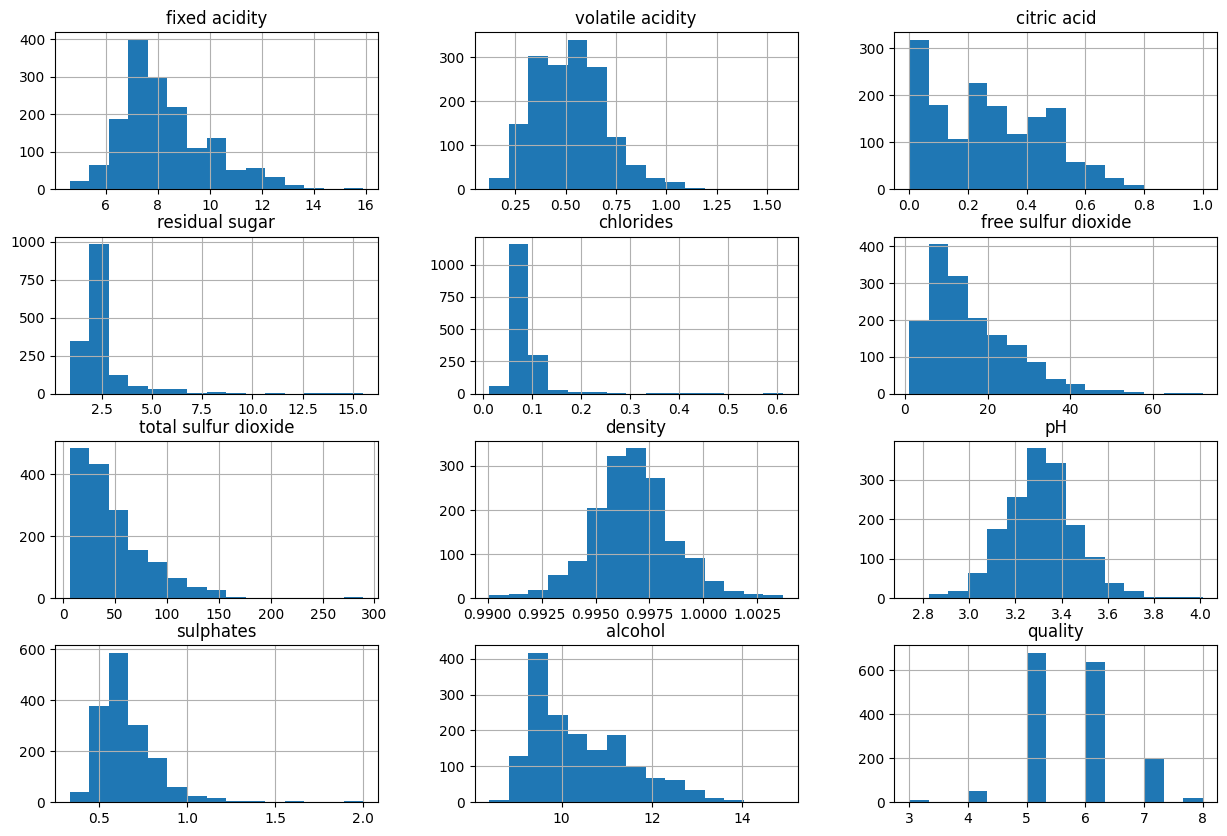

In [3]:
df.hist(bins=15, figsize=(15,10))

<Axes: >

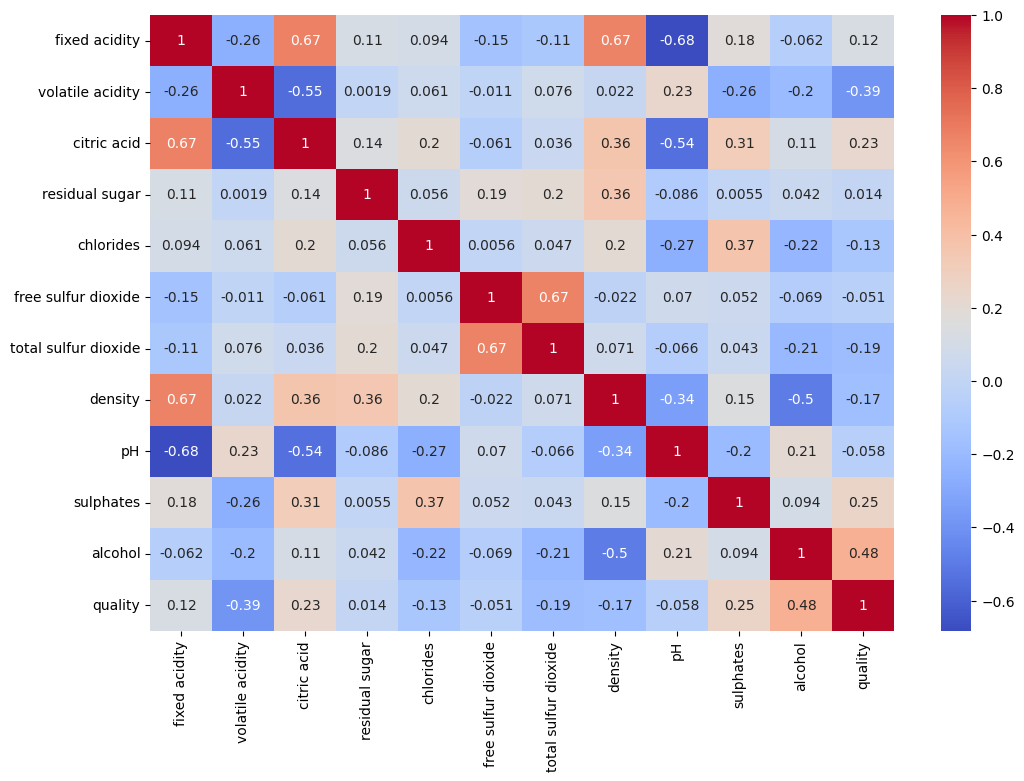

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')

<Axes: xlabel='quality', ylabel='alcohol'>

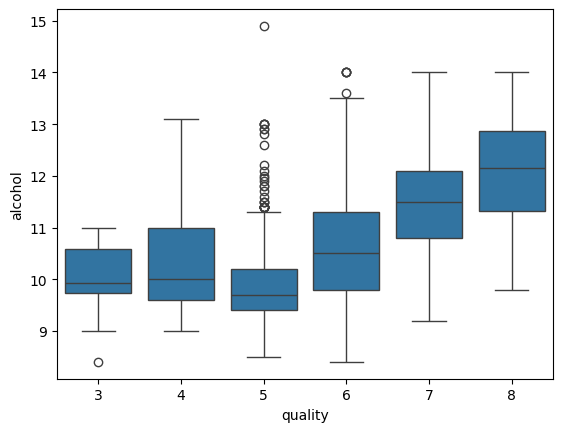

In [5]:
sns.boxplot(x='quality', y='alcohol', data=df)

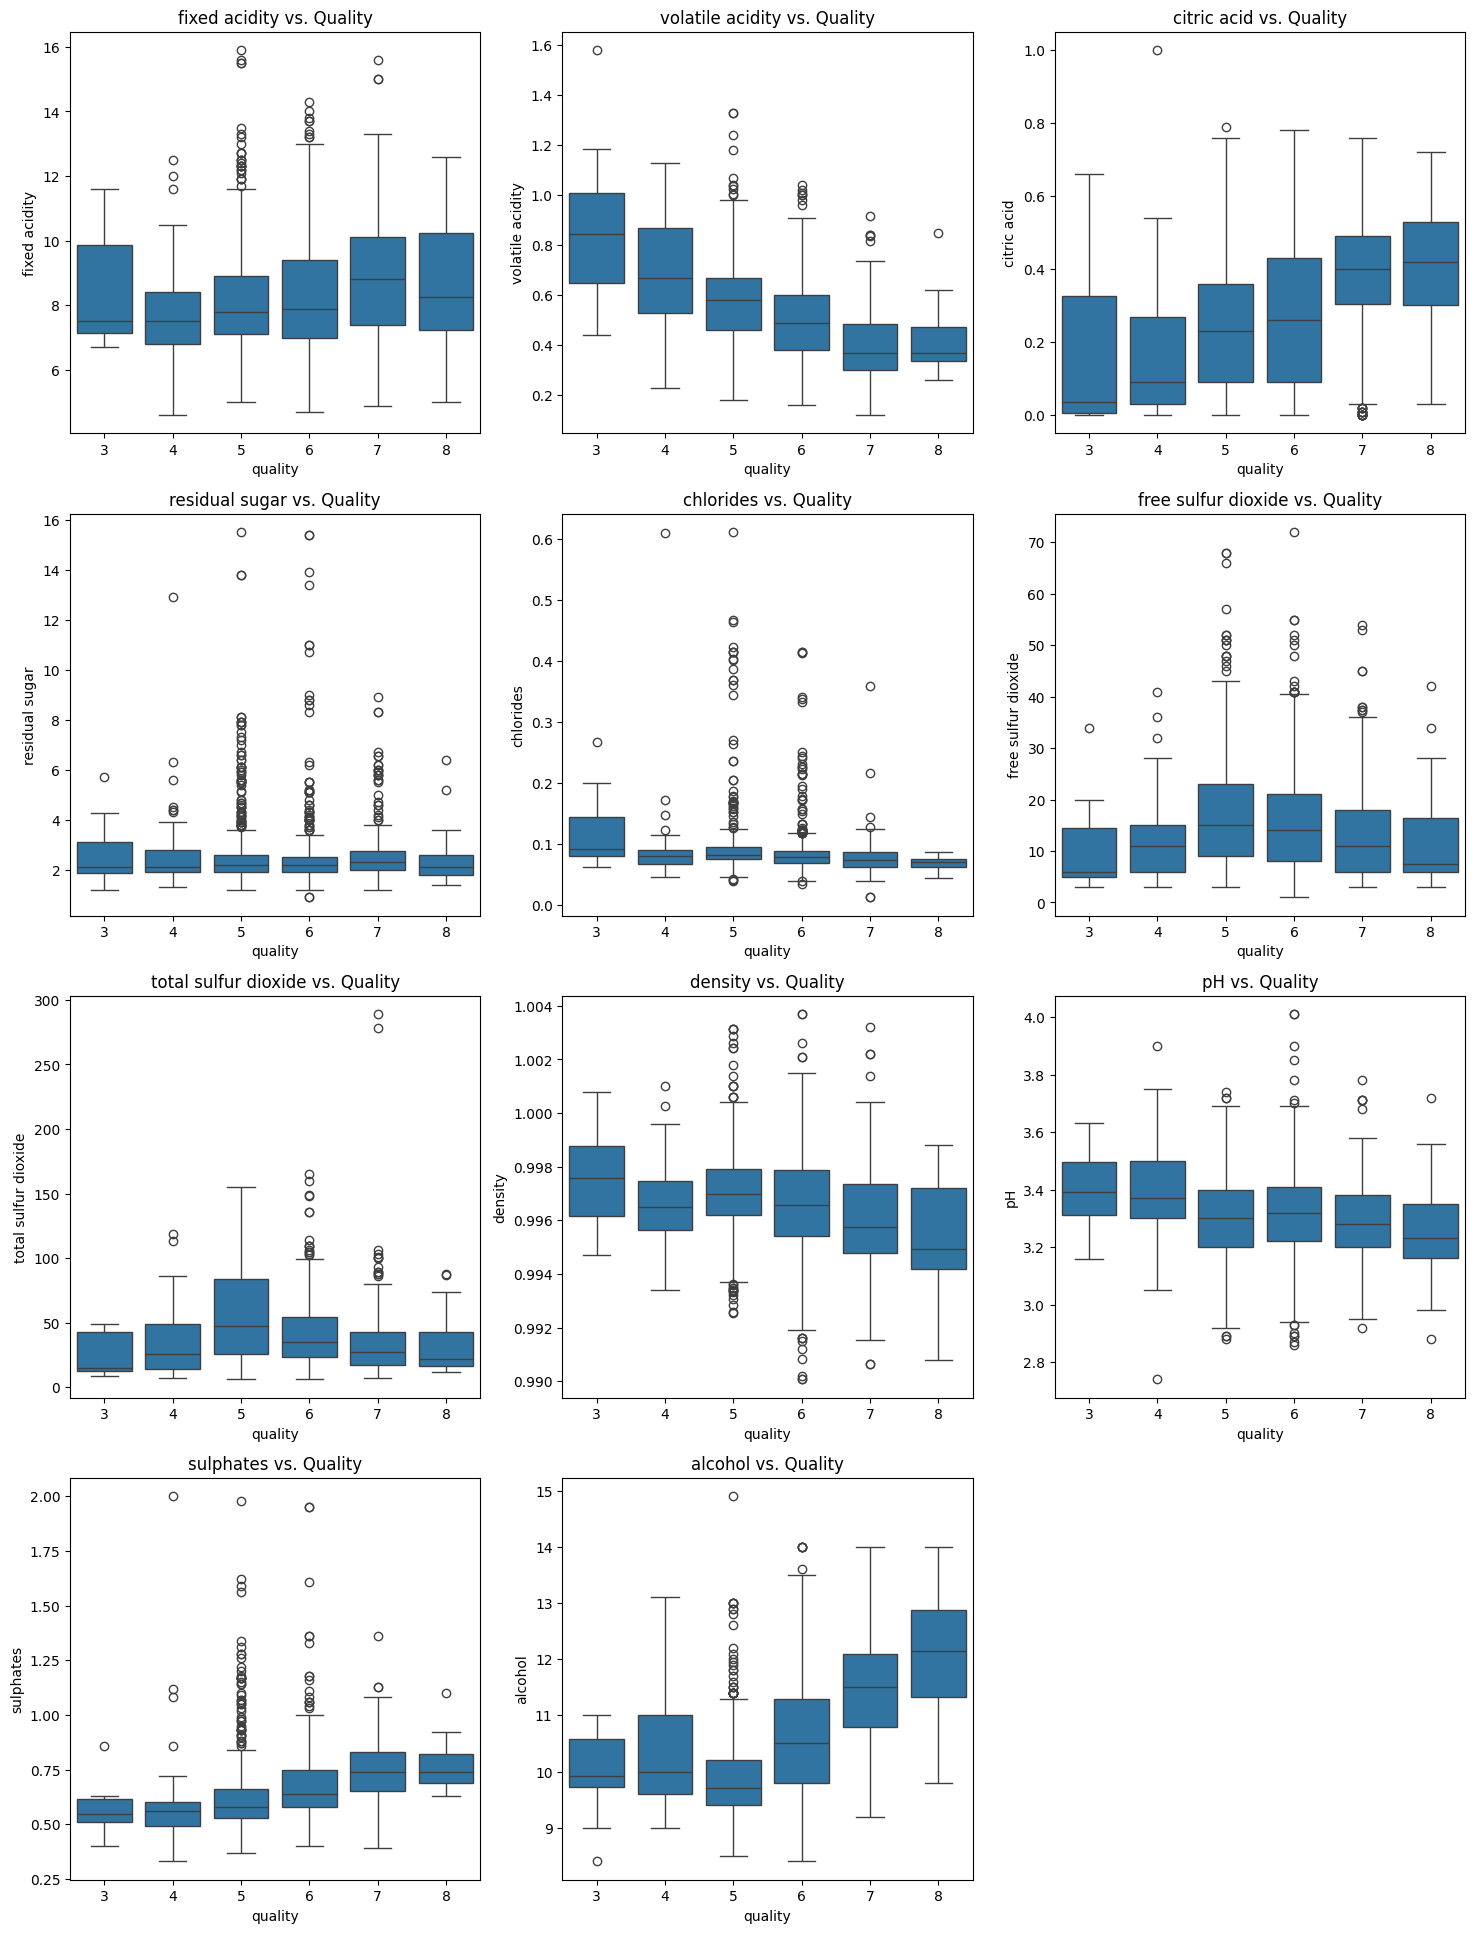

In [6]:
features = [col for col in df.columns if col != 'quality']
num_features = len(features)
cols = 3
rows = (num_features + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(18, 6 * rows))
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.boxplot(x='quality', y=feature, data=df, ax=axes[i])
    axes[i].set_title(f'{feature} vs. Quality')

for ax in axes[len(features):]:
    ax.axis('off')

---

# Pre-Processing

In [7]:
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = df.drop('quality', axis=1)
y = df['quality']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y, # Preserve distribution of y within groups
    random_state=42
)

scaler = StandardScaler() # Remove mean, scale to unit variance
# fit scalar on training data + apply to both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

---

# ANN Model

Main hyper-params to consider:
- num nodes and num nodes/layer
- regularization value --> MLPClassifier only supports L2 (alpha)
- learning rate
- early stopping
- batch size

In [9]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(
    hidden_layer_sizes=(100,),
    activation='relu', # non-linear
    solver='adam', # optomizer for updating weights
    alpha=0.0001,
    max_iter=300,
    n_iter_no_change=20,
    early_stopping=True, # automatically uses a validation split to determine if early stop encessary
    random_state=42
)

mlp.fit(X_train_scaled, y_train)

MLPClassifier(early_stopping=True, max_iter=300, n_iter_no_change=20,
              random_state=42)

In [10]:
# generate predictions and print performance
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = mlp.predict(X_test_scaled)
print("Classification report:\n")
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
styled_report = report_df.style.background_gradient(cmap='Blues').format("{:.2f}")
display(styled_report)

Classification report:



,precision,recall,f1-score,support
3,0.00,0.00,0.00,2.00
4,0.00,0.00,0.00,11.00
5,0.59,0.80,0.68,136.00
6,0.54,0.48,0.51,128.00
7,0.59,0.33,0.42,40.00
8,0.00,0.00,0.00,3.00
accuracy,0.57,0.57,0.57,0.57
macro avg,0.29,0.27,0.27,320.00
weighted avg,0.54,0.57,0.55,320.00


#### Terminology:
- Precision: % of predicted positives that ARE positive
- Recall: % of actual positives that WERE predicted as positive
- F1-score: Harmonic mean of precision and recall. 1 is perfect, 0 is bad.
    --> 0.6-0.7 is lowest acceptable, below that is weak
- Support: Number of true instances for each class in y_test.

- accuracy = correct pred / total pred
- macro avg = avg precision/recal/f-1 (respectively) over all classes. i.e the avgprecision is 0.29.
- weighted avg = like macro avg but takes into account # instances for each class --> helpful for imbalanced classes

#### Interpretation: 
- 57% of all preds were correct
- 3,4,8 had 0 correct classifications --> model biased to majority classes
- Class 5 has highest support AND best performance --> indicates bias to support
- Class 6 has pretty balanced precision/recal
- class 7 had poor recall, meaning it MISSED many of its instances

- weighted averages ~ double macro averages means bias to suppport. Accounting for weight gives better performance so higher weighted classes do better.

Pred      3    4    5    6    7    8


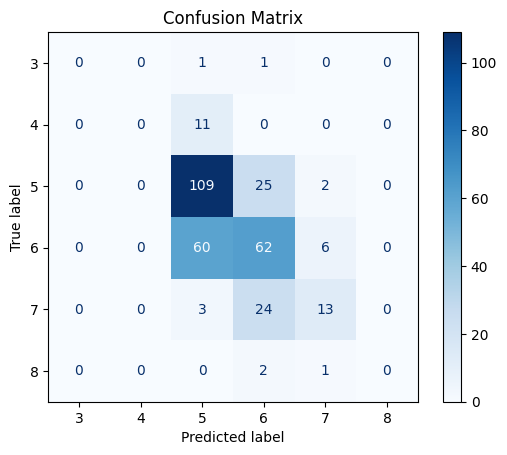

In [11]:
# confusion matrix
print("Pred      3    4    5    6    7    8")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

#### Reminder:
- Rows correspond to true class
- columns correspond to predicted class
- values on the main diagonal show correct predictons for each class
- values OFF diagonal show missclassifications
- Tells you which classes were missclassified as what

#### Observations:
- class 3 (2 total obs.) fully missclassified as one 5 and one 6
- class 4 entirely missclassified as 5
- class 5 had allmost all missclassifications (25/27) as class 6
- class 6 had majority missclassifications (60/66) as class 5
- class 7 had majority of missclassifications (24/27) as class 6
- class 8 (2 total obs.) full missclassified as one 7 and two 6

#### Interpretation:
- Seems to be an ordinal relationship between classes
- most missclassifications are as 5 or 6 because they dominate training of model

## Grid search:

#### Hyperparameters to optomize:
- hidden layer sizes (both nodes and nodes/layer)
- alpha
- learning rate

#### Method for Grid Search:
1) run a coarse grid covering a broad range of architectures to find best architecture
3) Fine tune around the best architecture to find the optimal combo in that area
4) once you know  the region, switch to randomized search to sample more surrounding combos
5) pick the simplest model that is close enough to best accuracy

### Course Grid

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score

param_grid = {
    'hidden_layer_sizes': [
        (50,),   # one small layer
        (100,),  # one medium layer
        (150,),  # one large layer
        (100, 50),  # two layers, tapered
        (150, 75),   # two larger layers, also tapered
        (200, 100),   # two layers, wider
        (100, 50, 25),# three layers, tapered
    ],
    'alpha': [1e-5, 1e-4, 1e-3],
    'learning_rate_init': [1e-4, 1e-3, 1e-2], 
}

grid = GridSearchCV(
    estimator=MLPClassifier(
        max_iter=500,
        early_stopping=True,
        random_state=42,
        solver="adam"
    ),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1, 
    verbose=1
)

grid.fit(X_train_scaled, y_train)

print("\nBest params:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)

course_grid_model = grid.best_estimator_
y_pred_course = course_grid_model.predict(X_test_scaled)
print("Test accuracy:", accuracy_score(y_test, y_pred_course))
print("Macro-F1:", f1_score(y_test, y_pred_course, average='macro'))

print("\nClassification report:\n")
report = classification_report(y_test, y_pred_course, output_dict=True)
report_df = pd.DataFrame(report).transpose()
styled_report = report_df.style.background_gradient(cmap='Blues').format("{:.2f}")
display(styled_report)

Fitting 5 folds for each of 63 candidates, totalling 315 fits

Best params: {'alpha': 1e-05, 'hidden_layer_sizes': (150, 75), 'learning_rate_init': 0.01}
Best CV accuracy: 0.6090533088235295
Test accuracy: 0.60625
Macro-F1: 0.30968932336271604

Classification report:



,precision,recall,f1-score,support
3,0.00,0.00,0.00,2.00
4,0.00,0.00,0.00,11.00
5,0.73,0.54,0.62,136.00
6,0.55,0.75,0.63,128.00
7,0.60,0.60,0.60,40.00
8,0.00,0.00,0.00,3.00
accuracy,0.61,0.61,0.61,0.61
macro avg,0.31,0.32,0.31,320.00
weighted avg,0.61,0.61,0.59,320.00


 ### Fine Grid

In [13]:
param_grid_fine = {
    # stick with mostly two layers, but try other combos
    'hidden_layer_sizes': [
        (150, 75), # current best
        (175, 90), # smaller
        (125, 60),      # even smaller
        (150, 75, 30),  # medium size third layer
        (100, 50), # baseline two layer
    ],
    # surrounding alphas
    'alpha': [1e-6, 5e-6, 1e-5, 5e-5],
    # surrounding lr
    'learning_rate_init': [0.005, 0.01, 0.02]
}

fine_grid = GridSearchCV(
    estimator=MLPClassifier(
        max_iter=500,
        early_stopping=True,
        random_state=42,
    ),
    param_grid=param_grid_fine,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

fine_grid.fit(X_train_scaled, y_train)

print("Best params:", fine_grid.best_params_)
print("Best CV accuracy:", fine_grid.best_score_)


fine_grid_model = fine_grid.best_estimator_
y_pred_fine = fine_grid_model.predict(X_test_scaled)

print("Test accuracy:", accuracy_score(y_test, y_pred_fine))
print("Macro-F1:", f1_score(y_test, y_pred_fine, average='macro'))

print("\nClassification report:\n")
report = classification_report(y_test, y_pred_fine, output_dict=True)
report_df = pd.DataFrame(report).transpose()
styled_report = report_df.style.background_gradient(cmap='Blues').format("{:.2f}")
display(styled_report)

Best params: {'alpha': 5e-05, 'hidden_layer_sizes': (125, 60), 'learning_rate_init': 0.02}
Best CV accuracy: 0.61453125
Test accuracy: 0.609375
Macro-F1: 0.2749127435622612

Classification report:



,precision,recall,f1-score,support
3,0.00,0.00,0.00,2.00
4,0.00,0.00,0.00,11.00
5,0.70,0.64,0.67,136.00
6,0.54,0.77,0.64,128.00
7,0.75,0.23,0.35,40.00
8,0.00,0.00,0.00,3.00
accuracy,0.61,0.61,0.61,0.61
macro avg,0.33,0.27,0.27,320.00
weighted avg,0.61,0.61,0.58,320.00


### Random Search

In [14]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform

param_dist = {
    # keep two layer
    'hidden_layer_sizes': [
        (125, 60), # current best
        (150, 75),    
        (100, 50), 
        (125, 60, 30),
        (150, 60),  
    ],
    'alpha': loguniform(1e-6, 1e-4),
    'learning_rate_init': loguniform(1e-3, 5e-2)
}

rs = RandomizedSearchCV(
    estimator=MLPClassifier(
        solver='adam',
        max_iter=500,
        early_stopping=True,
        random_state=42,
    ),
    param_distributions=param_dist,
    n_iter=100,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

rs.fit(X_train_scaled, y_train)

print("Best params:", rs.best_params_)
print("Best CV accuracy:", rs.best_score_)

random_search_model = rs.best_estimator_
y_pred_rs = random_search_model.predict(X_test_scaled)

print("Test accuracy:", accuracy_score(y_test, y_pred_rs))
print("Macro-F1:", f1_score(y_test, y_pred_rs, average='macro'))

print("\nClassification report:\n")
report = classification_report(y_test, y_pred_rs, output_dict=True)
report_df = pd.DataFrame(report).transpose()
styled_report = report_df.style.background_gradient(cmap='Blues').format("{:.2f}")
display(styled_report)

Best params: {'alpha': np.float64(1.4732618059500207e-06), 'hidden_layer_sizes': (125, 60, 30), 'learning_rate_init': np.float64(0.03362146348225422)}
Best CV accuracy: 0.6145465686274509
Test accuracy: 0.60625
Macro-F1: 0.2915540673520181

Classification report:



,precision,recall,f1-score,support
3,0.00,0.00,0.00,2.00
4,0.00,0.00,0.00,11.00
5,0.66,0.70,0.68,136.00
6,0.54,0.66,0.60,128.00
7,0.74,0.35,0.47,40.00
8,0.00,0.00,0.00,3.00
accuracy,0.61,0.61,0.61,0.61
macro avg,0.32,0.29,0.29,320.00
weighted avg,0.59,0.61,0.59,320.00


## Training Loss and Validation Accuracy

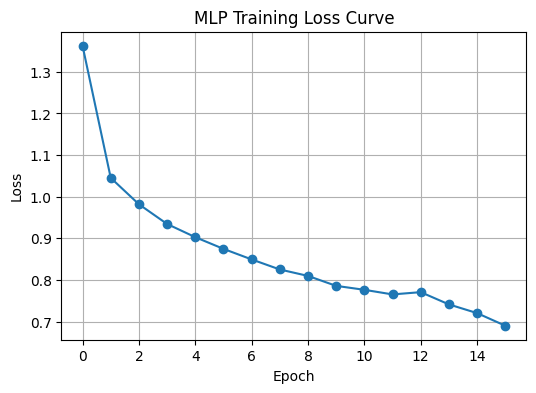

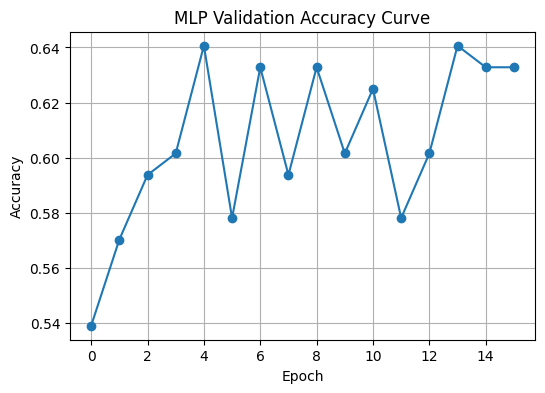

In [15]:
chosen_model = fine_grid_model

mlp = chosen_model

# 1. Plot training loss vs. epoch
plt.figure(figsize=(6,4))
plt.plot(mlp.loss_curve_, marker='o')
plt.title('MLP Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

if hasattr(mlp, 'validation_scores_'):
    plt.figure(figsize=(6,4))
    plt.plot(mlp.validation_scores_, marker='o')
    plt.title('MLP Validation Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()


#### Interpretation:
- No crazy spikes in training loss, converges smoothly. Model is still learning until about epoch 4, then it's just tweaking weights for minor improvements.
- Validation accuracy oscilates around 0.58-0.64. This area represents the model's ceiling for gnerealization.
- Training loss still decreases past where validation accuracy plateaus and validation accuracy doesn't collapse. Means regularization and network size are in a good spot, and the model isn't overfitting or underfitting too badly.

## ANN Model with Chosen Hyperparameters

Chosen Model Parameters:
hidden_layer_sizes: (125, 60)
activation: relu
solver: adam
alpha: 5e-05
learning_rate: constant
learning_rate_init: 0.02

Test Accuracy: 0.609375
Macro-F1: 0.2749127435622612

Classification report:



,precision,recall,f1-score,support
3,0.00,0.00,0.00,2.00
4,0.00,0.00,0.00,11.00
5,0.66,0.70,0.68,136.00
6,0.54,0.66,0.60,128.00
7,0.74,0.35,0.47,40.00
8,0.00,0.00,0.00,3.00
accuracy,0.61,0.61,0.61,0.61
macro avg,0.32,0.29,0.29,320.00
weighted avg,0.59,0.61,0.59,320.00



Confusion Matrix:


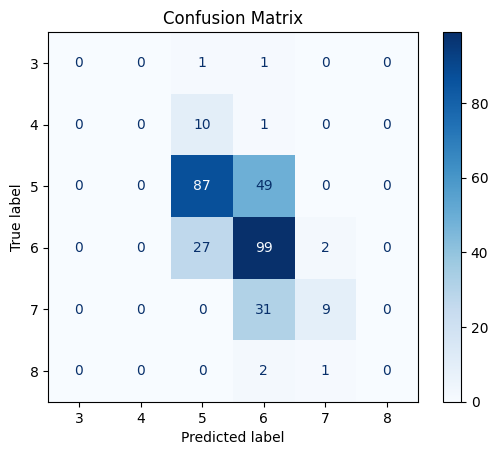

In [16]:
chosen_model.fit(X_train_scaled, y_train)
y_pred_final = chosen_model.predict(X_test_scaled)

hyperparams = chosen_model.get_params()
notable_keys = [
    "hidden_layer_sizes", "activation", "solver",
    "alpha", "learning_rate", "learning_rate_init",
]
notable_params = {k: hyperparams[k] for k in notable_keys if k in hyperparams}

print("Chosen Model Parameters:")
for param, value in notable_params.items():
    print(f"{param}: {value}")

print("\nTest Accuracy:", accuracy_score(y_test, y_pred_final))
print("Macro-F1:", f1_score(y_test, y_pred_final, average='macro'))

print("\nClassification report:\n")
report = classification_report(y_test, y_pred_rs, output_dict=True)
report_df = pd.DataFrame(report).transpose()
styled_report = report_df.style.background_gradient(cmap='Blues').format("{:.2f}")
display(styled_report)

print("\nConfusion Matrix:")
ConfusionMatrixDisplay.from_estimator(chosen_model, X_test_scaled, y_test, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

---

# Random Forest

## Basic Model

Accuracy: 0.68125
Classification report:



,precision,recall,f1-score,support
3,0.00,0.00,0.00,2.00
4,0.00,0.00,0.00,11.00
5,0.71,0.76,0.74,136.00
6,0.65,0.71,0.68,128.00
7,0.71,0.55,0.62,40.00
8,0.50,0.33,0.40,3.00
accuracy,0.68,0.68,0.68,0.68
macro avg,0.43,0.39,0.41,320.00
weighted avg,0.66,0.68,0.67,320.00


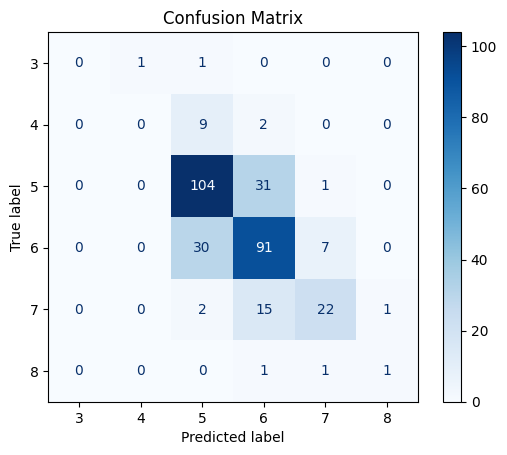

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, ConfusionMatrixDisplay

rf_model = RandomForestClassifier(
    n_estimators=100, # num trees
    max_depth=None, 
    random_state=42
)

rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)


print("Accuracy:", accuracy_score(y_test, y_pred_rf))

print("Classification report:\n")
report = classification_report(y_test, y_pred_rf, output_dict=True)
report_df = pd.DataFrame(report).transpose()
styled_report = report_df.style.background_gradient(cmap='Blues').format("{:.2f}")
display(styled_report)

ConfusionMatrixDisplay.from_estimator(rf_model, X_test_scaled, y_test, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

Notes on Terminology:
- Precision: % of predicted positives that ARE positive
- Recall: % of actual positives that WERE predicted as positive
- F1-score: Harmonic mean of precision and recall. 1 is perfect, 0 is bad.
    --> 0.6-0.7 is lowest acceptable, below that is weak
- Support: Number of true instances for each class in y_test.
- accuracy = correct pred / total pred
- macro avg = avg precision/recal/f-1 (respectively) over all classes. i.e the avgprecision is 0.29.
- weighted avg = like macro avg but takes into account # instances for each class --> helpful for imbalanced classes

Interpretation: 
- 68% of all predictions were correct
- Classes 3 and 4 were almost entirely missclassified as class 5
- Class 5 and 6 dominate the dataset, and as a result have the most accuracy. They were frequently missclassified as eachother (31 class 5's classified as 6's, 30 class 6's classified as class 5's)
- Class 8 almost entirely missclassified, but has higher results than other minority classes because 1/3 were predicted correctly. Seems to be picked up more by the model than class 4 despite class 4 having more instances, likely because class 8 is further from a dominating class so it blends in less.
- Macro averages are lower than weighed averages, again indicating class imbalance. Low generalization to minority classes.
- Weighted averages are higher ~67%, indicating stronger performance of majority classes

## Hyperparameter Tuning

Main hyper-params to consider:
- n_estimators: number of trees in the forest
- max_depth: max depth a tree can have
- min_samples_split: min number of samples that must be present in a node before the model tries to split it into smaller nodes. If node has fewer samples than this, it automatically becomes a leaf. Helps prevent overfitting by stoping tree from going too deep and learning noise of the data. Larger value = simpler tree.
- min_samples_leaf: min number of samplesthat must be present in a node for that node to be a leaf. i.e if the parent node splits and one node has less than min_samples_leaf, then that split is disallowed. This also prevents model from creating leaves that are too specific (overfitting). Can also be set as a float (a percentage of the total number of samples).

### Grid Search

In [18]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [25, 50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,   
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

print("Best parameters:", grid_search.best_params_)
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test_scaled)

print("Test Accuracy:", accuracy_score(y_test, y_pred_best))
print("Macro-F1:", f1_score(y_test, y_pred_best, average='macro'))


print("\nClassification report:\n")
report = classification_report(y_test, y_pred_best, output_dict=True)
report_df = pd.DataFrame(report).transpose()
styled_report = report_df.style.background_gradient(cmap='Blues').format("{:.2f}")
display(styled_report)

Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Test Accuracy: 0.68125
Macro-F1: 0.3406232296076553

Classification report:



,precision,recall,f1-score,support
3,0.00,0.00,0.00,2.00
4,0.00,0.00,0.00,11.00
5,0.72,0.76,0.74,136.00
6,0.64,0.73,0.68,128.00
7,0.78,0.53,0.63,40.00
8,0.00,0.00,0.00,3.00
accuracy,0.68,0.68,0.68,0.68
macro avg,0.35,0.34,0.34,320.00
weighted avg,0.66,0.68,0.66,320.00


### Visualizing Hyperparameter Combinations

In [19]:
# convert grid search results to a df
results_df = pd.DataFrame(grid_search.cv_results_)

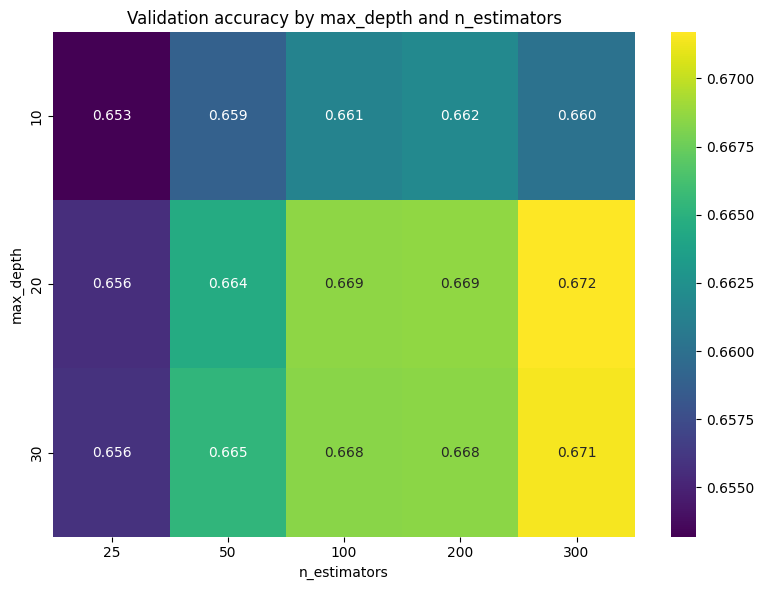

In [20]:
# create a pivot tabel to use for heat map
pivot_table = results_df.pivot_table(
    values='mean_test_score',
    index='param_max_depth',
    columns='param_n_estimators'
)

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="viridis")
plt.title("Validation accuracy by max_depth and n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.tight_layout()
plt.show()

#### Max depth vs num total trees
The accuracies here show max depth of 20 and 30 to have a slight edge over 10. For n_estimators, values of 100,200, and 300 have a slight edge. Grid search chose max depth = 20, n_estimators = 100, which we agree with because its the simplest model that achieves the highest accuracy.

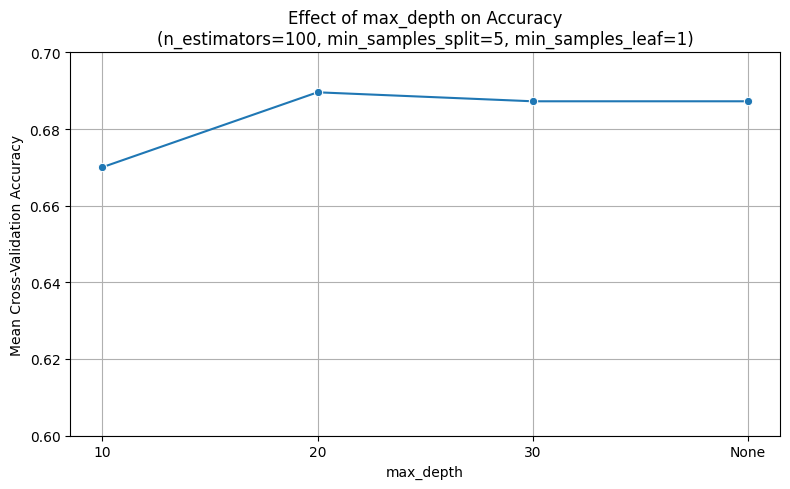

In [21]:
# hold all other params at optimal values
filtered_df = results_df[
    (results_df['param_n_estimators'] == 100) &
    (results_df['param_min_samples_split'] == 5) &
    (results_df['param_min_samples_leaf'] == 1)
]

# sort values by max_depth
filtered_df = filtered_df.sort_values(by='param_max_depth')

plt.figure(figsize=(8, 5))
sns.lineplot(
    x=filtered_df['param_max_depth'].astype(str),
    y=filtered_df['mean_test_score'],
    marker='o'
)
plt.title("Effect of max_depth on Accuracy\n(n_estimators=100, min_samples_split=5, min_samples_leaf=1)")
plt.xlabel("max_depth")
plt.ylabel("Mean Cross-Validation Accuracy")
plt.ylim(0.6, 0.7)
plt.grid(True)
plt.tight_layout()
plt.show()

#### Max Depth alone
Here we see accuracy decrease after optimal max depth of 20.

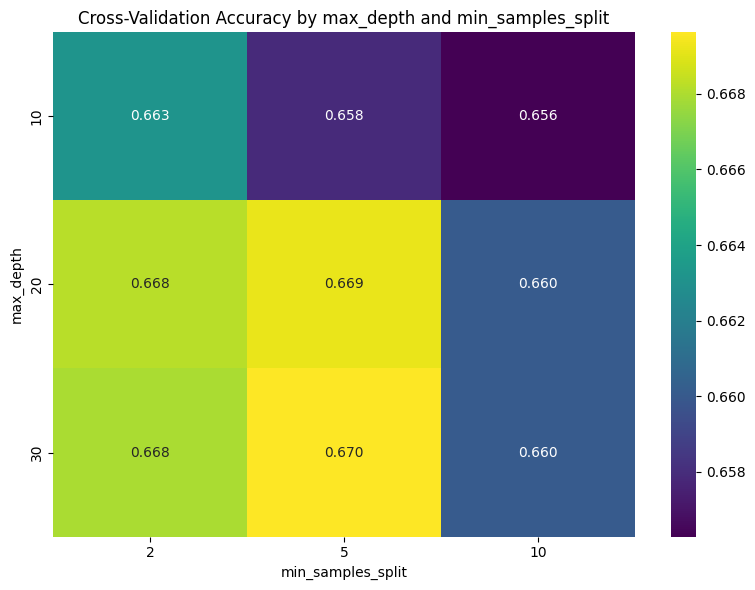

In [22]:
pivot_table2 = results_df.pivot_table(
    values='mean_test_score',
    index='param_max_depth',
    columns='param_min_samples_split'
)

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table2, annot=True, fmt=".3f", cmap="viridis")
plt.title("Cross-Validation Accuracy by max_depth and min_samples_split")
plt.xlabel("min_samples_split")
plt.ylabel("max_depth")
plt.tight_layout()
plt.show()

#### Max depth vs min samples split
Only marginal gains going from 20:5 (max_depth:min_samples_split) to 30:50, and we still choose max_depth = 20 based on the previous graphs

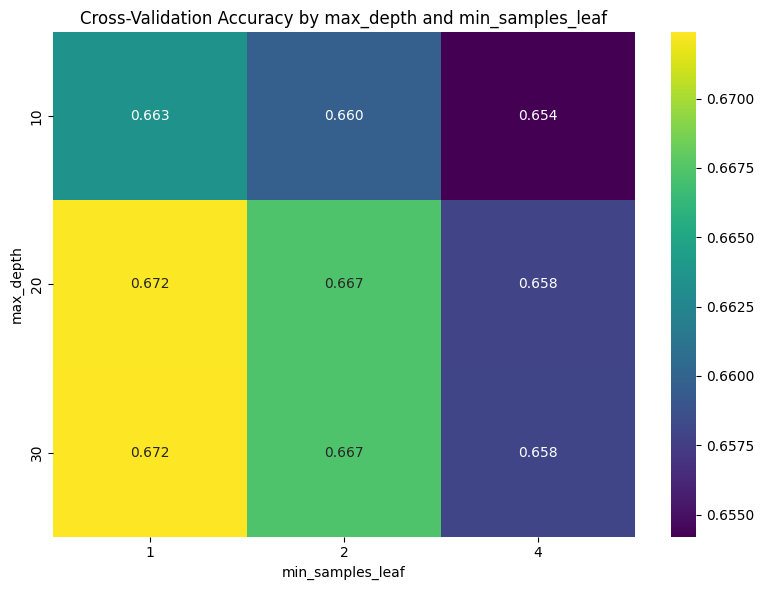

In [23]:
pivot_table3 = results_df.pivot_table(
    values='mean_test_score',
    index='param_max_depth',
    columns='param_min_samples_leaf'
)

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table3, annot=True, fmt=".3f", cmap="viridis")
plt.title("Cross-Validation Accuracy by max_depth and min_samples_leaf")
plt.xlabel("min_samples_leaf")
plt.ylabel("max_depth")
plt.tight_layout()
plt.show()

#### max depth vs min samples leaf
Here we see the optimal min samples leaf is clearly 1, and again we go with max_depth 20 based on graphs above.

#### OVERALL:
The visualizations confirm that the grid search hyperparameter values chosen are valid and not overfit. This confirms our ballpark estimate of the best parameters, but we can also try random searching for similar models that might be better. Here we can skip the fine grid search step because our course grid gives us a more conclusive estimate than in ANN where there are many more possibly valid combinations.

### Random Search in the area

In [24]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

param_dist = {
    'n_estimators': randint(50, 501), # up to 500 trees
    'max_depth': [None] + list(range(5, 51, 5)), # none or shallow - deep
    'min_samples_split': randint(2, 21),
    'min_samples_leaf': randint(1, 5),
}

rf = RandomForestClassifier(random_state=42)
rnd_search = RandomizedSearchCV(
  estimator=rf,
  param_distributions=param_dist,
  n_iter=100,
  cv=5,
  scoring='accuracy',
  random_state=42,
  n_jobs=-1,
)

rnd_search.fit(X_train_scaled, y_train)


print("Best params from random search:", rnd_search.best_params_)
random_rf = rnd_search.best_estimator_
y_pred_random = random_rf.predict(X_test_scaled)

print("Test Accuracy:", accuracy_score(y_test, y_pred_random))
print("Macro-F1:", f1_score(y_test, y_pred_random, average='macro'))

print("\nClassification report:\n")
report = classification_report(y_test, y_pred_random, output_dict=True)
report_df = pd.DataFrame(report).transpose()
styled_report = report_df.style.background_gradient(cmap='Blues').format("{:.2f}")
display(styled_report)

Best params from random search: {'max_depth': 25, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 363}
Test Accuracy: 0.68125
Macro-F1: 0.3387452643962027

Classification report:



,precision,recall,f1-score,support
3,0.00,0.00,0.00,2.00
4,0.00,0.00,0.00,11.00
5,0.72,0.75,0.73,136.00
6,0.63,0.75,0.68,128.00
7,0.80,0.50,0.62,40.00
8,0.00,0.00,0.00,3.00
accuracy,0.68,0.68,0.68,0.68
macro avg,0.36,0.33,0.34,320.00
weighted avg,0.66,0.68,0.66,320.00


### Comparing Chosen Models

- The grid search best model trained above and the random search beset model both have the exact same test accuracy of ~68.1%, and the random search model has slightly lower macro-f1. Random search chose a model with more trees (363 compared to 100) and chose deeper trees (25 compared to 20) with more splits (min_samples_split of 2 compared to 5). The more trees model is more complicated for the same accuracy outcome, so we will proceed with the model we got from the intial grid seaech.
- The fact that two models with very different hyperparameter lists converged on the same accuracy indivated that this is a natural ceiling for the model applied to this dataset.

## Random Forest Model with chosen hyperparameters

Best parameters:
n_estimators: 100
max_depth: 20
min_samples_split: 5
min_samples_leaf: 1
Test Accuracy: 0.68125
Macro-F1: 0.3406232296076553

Classification report:



,precision,recall,f1-score,support
3,0.00,0.00,0.00,2.00
4,0.00,0.00,0.00,11.00
5,0.72,0.76,0.74,136.00
6,0.64,0.73,0.68,128.00
7,0.78,0.53,0.63,40.00
8,0.00,0.00,0.00,3.00
accuracy,0.68,0.68,0.68,0.68
macro avg,0.35,0.34,0.34,320.00
weighted avg,0.66,0.68,0.66,320.00


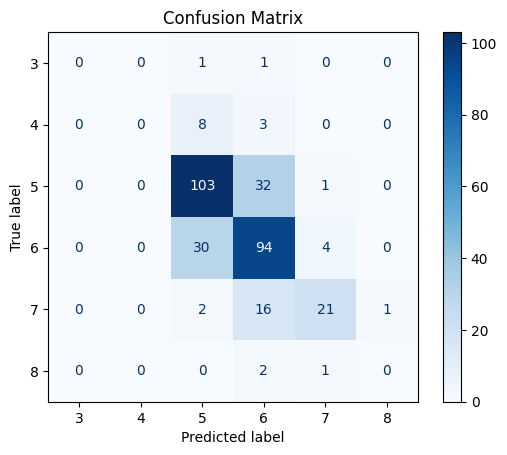

In [25]:
chosen_model = best_rf
hyperparams = chosen_model.get_params()

notable_keys = [
    "n_estimators", "max_depth", "min_samples_split",
    "min_samples_leaf"
]

notable_params = {k: hyperparams[k] for k in notable_keys if k in hyperparams}

y_pred_final = chosen_model.predict(X_test_scaled)

print("Best parameters:")
for param, value in notable_params.items():
    print(f"{param}: {value}")
print("Test Accuracy:", accuracy_score(y_test, y_pred_best))
print("Macro-F1:", f1_score(y_test, y_pred_best, average='macro'))

print("\nClassification report:\n")
report = classification_report(y_test, y_pred_best, output_dict=True)
report_df = pd.DataFrame(report).transpose()
styled_report = report_df.style.background_gradient(cmap='Blues').format("{:.2f}")
display(styled_report)

ConfusionMatrixDisplay.from_estimator(chosen_model, X_test_scaled, y_test, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

---

# KNN Model

## Using a Pipeline

Knn is distance based, so if one  features has a wider range than another it will dominate the search. To combat this, we use a pipeline with a scalar inside it. Now during CV each fold's training data is scaled independently to maintain consistant scale.

Thii pipeline will first scale the set, then apply knn classifier to it.

In [26]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline      import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors     import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier()
# standard scaling = subtract mean divide by std
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn',    KNeighborsClassifier())
])

## Grid Search

#### Hyperparameters to tune:
- number of neighbors = how many neighbors it calculates for each point to base class assignment off of
- weights = how to weight the classes of each neighbor on the final decision. 'uniform' is default, where all neighbors regardless of distance are equally weighted- majority vote wins. 'distance' means that closer neighbors' classes are weighted more heavily on the final class assignment.
- distance metric: how to define distance between two instances. Candidates are manhatten and euclidian distane.

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best params:     {'knn__n_neighbors': 12, 'knn__p': 2, 'knn__weights': 'distance'}
Best CV acc:     0.6708272058823529

Accuracy on test set:  0.653125

Test‐set classification report:



,precision,recall,f1-score,support
3,0.00,0.00,0.00,2.00
4,0.00,0.00,0.00,11.00
5,0.73,0.70,0.71,136.00
6,0.60,0.72,0.65,128.00
7,0.62,0.53,0.57,40.00
8,0.50,0.33,0.40,3.00
accuracy,0.65,0.65,0.65,0.65
macro avg,0.41,0.38,0.39,320.00
weighted avg,0.63,0.65,0.64,320.00


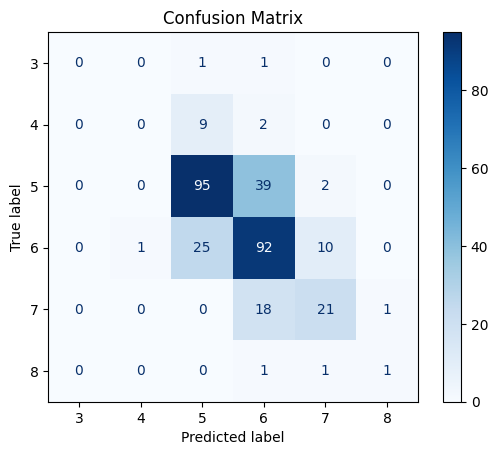

Rank 1:
Params: {'knn__n_neighbors': 12, 'knn__p': 2, 'knn__weights': 'distance'}
Mean Test Score: 0.6708272058823529
---
Rank 2:
Params: {'knn__n_neighbors': 13, 'knn__p': 2, 'knn__weights': 'distance'}
Mean Test Score: 0.6645649509803921
---
Rank 3:
Params: {'knn__n_neighbors': 14, 'knn__p': 1, 'knn__weights': 'distance'}
Mean Test Score: 0.6638143382352941
---
Rank 4:
Params: {'knn__n_neighbors': 11, 'knn__p': 2, 'knn__weights': 'distance'}
Mean Test Score: 0.663795955882353
---
Rank 5:
Params: {'knn__n_neighbors': 24, 'knn__p': 1, 'knn__weights': 'distance'}
Mean Test Score: 0.6630147058823529
---
Rank 6:
Params: {'knn__n_neighbors': 10, 'knn__p': 2, 'knn__weights': 'distance'}
Mean Test Score: 0.6622273284313726
---
Rank 7:
Params: {'knn__n_neighbors': 15, 'knn__p': 2, 'knn__weights': 'distance'}
Mean Test Score: 0.6622212009803922
---
Rank 8:
Params: {'knn__n_neighbors': 30, 'knn__p': 1, 'knn__weights': 'distance'}
Mean Test Score: 0.6614583333333333
---
Rank 9:
Params: {'knn__n_

In [27]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score

k_range_limit = 30
param_grid = {
    'knn__n_neighbors': list(range(1, k_range_limit+1)),       # k from 1 to 30
    'knn__weights':     ['uniform', 'distance'],  # uniform vs. distance‐weighted
    'knn__p':           [1, 2],                  # p=1 → Manhattan; p=2 → Euclidean
}

# use the pipeline for testing instead of just a standalone knn model
grid_knn = GridSearchCV(
    estimator = pipe,
    param_grid = param_grid,
    cv         = 5,         
    scoring    = 'accuracy',   
    n_jobs     = -1,     
    return_train_score=True, # return the training scores for analysis later
    verbose    = 1
)

grid_knn.fit(X_train, y_train)

# Store these vars for later analysis
best_model = grid_knn.best_estimator_
best_params = grid_knn.best_params_
best_cv_accruacy = grid_knn.best_score_
best_index = grid_knn.best_index_
best_cv_results = pd.DataFrame(grid_knn.cv_results_)
optimal_k = best_params['knn__n_neighbors']
optimal_weight = best_params['knn__weights']
optimal_p = best_params['knn__p']


print("Best params:    ", best_params)
print("Best CV acc:    ", best_cv_accruacy)

# evaluate best model on test set
best_y_pred = grid_knn.predict(X_test)
y_pred = grid_knn.predict(X_test)
print("\nAccuracy on test set: ", accuracy_score(y_test, y_pred))

# classification report and confusion report, nicely styled
print("\nTest‐set classification report:\n")
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
styled_report = report_df.style.background_gradient(cmap='Blues').format("{:.2f}")
display(styled_report)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


# print the top 10 best performing models for comparison
all_results = pd.DataFrame(grid_knn.cv_results_)
ten_best_models = all_results.sort_values(by='rank_test_score').head(10)
for _, row in ten_best_models.iterrows():
    print(f"Rank {row['rank_test_score']}:")
    print(f"Params: {row['params']}")
    print(f"Mean Test Score: {row['mean_test_score']}")
    print("---")

#### Observations:
- 'distance' is a clear winner for weights
- for distance metric and k value, there is no clear winner. the K values seem to sit in the range of 10-30.
- Top 4 performing models all have k values between 10-15, so this may be a sweet spot.

In the following graph, we can compare accuracies for different k values and distance metrics, while holding the weight the same (distance)

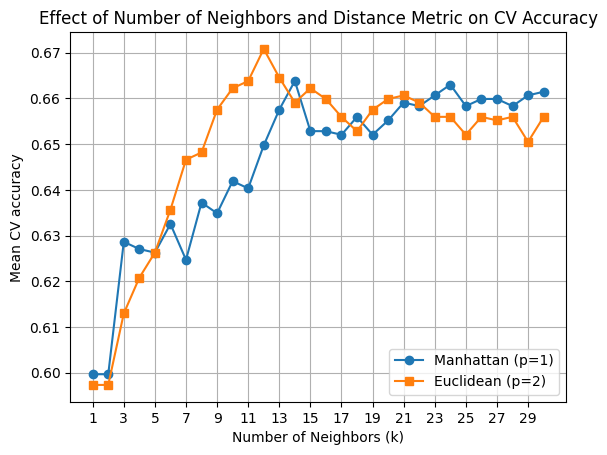

In [28]:
# 1) Filter to distance weighting only and grap k and p vals
results = pd.DataFrame(grid_knn.cv_results_)
filtered_weight = results[results['param_knn__weights'] == 'distance']
filtered_weight['k'] = filtered_weight['param_knn__n_neighbors'].astype(int)
filtered_weight['p'] = filtered_weight['param_knn__p'].astype(int)

# create pivot then plot
pivot_dist = filtered_weight.pivot(index='k', columns='p', values='mean_test_score')
plt.plot(pivot_dist.index, pivot_dist[1], marker='o', label='Manhattan (p=1)')
plt.plot(pivot_dist.index, pivot_dist[2], marker='s', label='Euclidean (p=2)')

plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean CV accuracy')
plt.title('Effect of Number of Neighbors and Distance Metric on CV Accuracy')
plt.xticks(range(1, k_range_limit, 2))
plt.legend()
plt.grid(True)
plt.show()

Observations:
- Both Euclidean and Manhatten dist. curves plateau from k = 13 on, sitting between 0.65 and 0.67
- Euclidean dist. is clearly more effective for lower k values, and peaks at 10-13.
- Manhatten dist. gradually climbs and is consistantly higher than euclidean dist. for k > 23

Interpretation:
- the plauteau indicates that the model isn't incredibly sensitive to k onces we reach mid teens, but is slightly sensitive to distance metric in teh later part of that region.
- lower k values risk overfitting, but also decrease bias

In [29]:
# compare training scores with cv scores
print("Best params: ", grid_knn.best_params_)
train_score = best_cv_results.loc[best_index, 'mean_train_score']
valid_score = best_cv_results.loc[best_index, 'mean_test_score']
print(f"Train CV score: {train_score:.3f}")
print(f"Valid CV score: {valid_score:.3f}")

Best params:  {'knn__n_neighbors': 12, 'knn__p': 2, 'knn__weights': 'distance'}
Train CV score: 1.000
Valid CV score: 0.671


Best params:  {'knn__n_neighbors': 12, 'knn__p': 2, 'knn__weights': 'distance'}


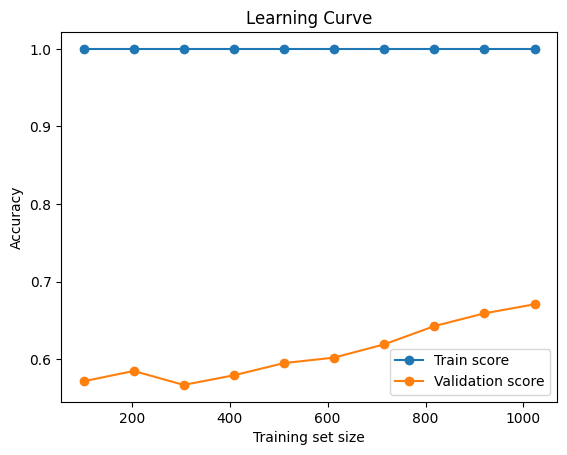

In [30]:
# graph training score compared to validation score for increasing trianing sizes
from sklearn.model_selection import learning_curve

# use the best model from grid search above
best_model
print("Best params: ", best_params)

# returns sizes of training sets, scores on each train set, scores on validation sets
train_sizes, train_scores, validation_scores = learning_curve(
    best_model,
    X_train, y_train,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10), # % of data to train on (min 10%)
    n_jobs=-1
)

# compute means and stds
train_mean = train_scores.mean(axis=1)
validation_mean = validation_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, 'o-', label='Train score')
plt.plot(train_sizes, validation_mean, 'o-', label='Validation score')
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()

- KNN is a high variance model, so we expect to see the gap between training score and validation score. In this case, the model will always reach 100% accuracy on training folds, which is expected given thet rianing set contains the query points themselves
- To check overfitting, we want to check the model's validation accuracy against the test accuracy. If we see a big drop, that means the model is likely overfit.

# KNN Model with chosen hyperparameters

Chosen Model Parameters:
Number of neighbors (k): 12
Weights: distance
Distance Metric (p): 2
Accuracy: 0.653125
Macro-F1: 0.3894429253859859

Classification report:



,precision,recall,f1-score,support
3,0.00,0.00,0.00,2.00
4,0.00,0.00,0.00,11.00
5,0.73,0.70,0.71,136.00
6,0.60,0.72,0.65,128.00
7,0.62,0.53,0.57,40.00
8,0.50,0.33,0.40,3.00
accuracy,0.65,0.65,0.65,0.65
macro avg,0.41,0.38,0.39,320.00
weighted avg,0.63,0.65,0.64,320.00



Confusion Matrix:


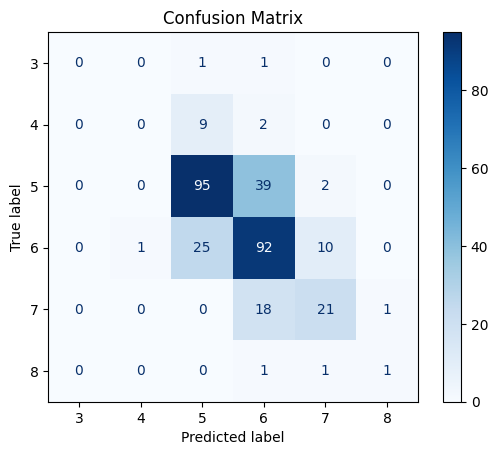

In [31]:
# initialize final chosen model
chosen_model = KNeighborsClassifier(
    n_neighbors=optimal_k,    
    weights=optimal_weight, 
    p=optimal_p,
    n_jobs=-1  
)


chosen_model.fit(X_train_scaled, y_train)
y_pred = chosen_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

print("Chosen Model Parameters:")
print("Number of neighbors (k):", optimal_k)
print("Weights:", optimal_weight )
print("Distance Metric (p):", optimal_p)


print(f"Accuracy: {accuracy}")
print("Macro-F1:", f1_score(y_test, y_pred, average='macro'))

print("\nClassification report:\n")
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
styled_report = report_df.style.background_gradient(cmap='Blues').format("{:.2f}")
display(styled_report)

print("\nConfusion Matrix:")
ConfusionMatrixDisplay.from_estimator(chosen_model, X_test_scaled, y_test, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

There is minial difference between the chosen model's validation accuracy and its accuracy on the held out test data, meaning it's not overfit and we can proceed with this model.